# ANN Tensorflow Implementation

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

from sklearn.metrics import confusion_matrix

import tensorflow as tf
print(tf.__version__)

Using TensorFlow backend.


2.4.0-rc4


In [2]:
import os

# disable gpu for cpu runtime test
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Prepare Dataset

In [3]:
datasetPath = "../Dataset/balanced-74Attributes-top17_ProtocolName.csv"
df = pd.read_csv(datasetPath)
#df = pd.read_csv(datasetPath, nrows=100000)
df.head()

,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,Total.Length.of.Fwd.Packets,Total.Length.of.Bwd.Packets,...,Active.Mean,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,L7Protocol,ProtocolName
0,3232238138,55681,180881158,3128,6,19002242,3,17,6,30.0,...,7352281.0,0.000000,7352281.0,7352281.0,11649832.0,0.000000e+00,11649832.0,11649832.0,131,HTTP_PROXY
1,180881160,3128,3232246304,53107,6,119684671,1006,898,1398550,5388.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,131,HTTP_PROXY
2,3232243804,59584,180881158,3128,6,118953292,24,66,1325,5077.0,...,336393.6,238675.043634,655083.0,172.0,23388871.8,7.972935e+06,29761260.0,12118217.0,131,HTTP_PROXY
3,182845710,53446,180881157,3128,6,59992665,3,3,18,63.0,...,120.0,91.923882,185.0,55.0,29995813.0,2.121108e+07,44994310.0,14997316.0,131,HTTP_PROXY
4,3232254003,21192,180881159,3128,6,1413924,22,0,4622,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,131,HTTP_PROXY


In [4]:
#df.drop(['Source.IP', 'Destination.IP'], axis = 1, inplace = True)
#df.drop(['Source.Port', 'Destination.Port'], axis = 1, inplace = True)

In [5]:
# Encode label for ProtocolName column

encoder = LabelEncoder().fit(df['ProtocolName'])
df['ProtocolName'] = encoder.fit_transform(df['ProtocolName'])
df.head()

,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Flow.Duration,Total.Fwd.Packets,Total.Backward.Packets,Total.Length.of.Fwd.Packets,Total.Length.of.Bwd.Packets,...,Active.Mean,Active.Std,Active.Max,Active.Min,Idle.Mean,Idle.Std,Idle.Max,Idle.Min,L7Protocol,ProtocolName
0,3232238138,55681,180881158,3128,6,19002242,3,17,6,30.0,...,7352281.0,0.000000,7352281.0,7352281.0,11649832.0,0.000000e+00,11649832.0,11649832.0,131,8
1,180881160,3128,3232246304,53107,6,119684671,1006,898,1398550,5388.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,131,8
2,3232243804,59584,180881158,3128,6,118953292,24,66,1325,5077.0,...,336393.6,238675.043634,655083.0,172.0,23388871.8,7.972935e+06,29761260.0,12118217.0,131,8
3,182845710,53446,180881157,3128,6,59992665,3,3,18,63.0,...,120.0,91.923882,185.0,55.0,29995813.0,2.121108e+07,44994310.0,14997316.0,131,8
4,3232254003,21192,180881159,3128,6,1413924,22,0,4622,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,131,8


In [6]:
X = df.drop('ProtocolName',axis=1)
Y = df['ProtocolName']
dummy_y = np_utils.to_categorical(Y)

X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, train_size=0.7, random_state=42)

In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

## Train Model

In [9]:
import tensorflow.keras.backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# yukarıdakiler yerine bu da kullanılabilir
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [10]:
# Build the model using functional Api
i = Input(shape=input_shape)
x = Dense(256, activation="relu")(i)
x = Dense(128, activation="relu")(x)
x = Dense(128, activation="relu")(x)
#x = Dense(64, activation="relu")(i)
x = Dense(num_classes, activation="softmax")(x)

model = Model(i, x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 73)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               18944     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 17)                2193      
Total params: 70,545
Trainable params: 70,545
Non-trainable params: 0
_________________________________________________________________


In [11]:
checkpoint_filepath = 'checkpoints/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', precision_m, recall_m, f1_m])

In [13]:
%load_ext memory_profiler

In [14]:
%%time
%memit history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[model_checkpoint_callback])

Epoch 1/100
2692/2692 [==============================] - 4s 1ms/step - loss: 1.1078 - accuracy: 0.6190 - val_loss: 0.4328 - val_accuracy: 0.8407
Epoch 2/100
2692/2692 [==============================] - 3s 1ms/step - loss: 0.4166 - accuracy: 0.8403 - val_loss: 0.3444 - val_accuracy: 0.8499
Epoch 3/100
2692/2692 [==============================] - 3s 1ms/step - loss: 0.3293 - accuracy: 0.8764 - val_loss: 0.2468 - val_accuracy: 0.9161
Epoch 4/100
2692/2692 [==============================] - 4s 1ms/step - loss: 0.2777 - accuracy: 0.8988 - val_loss: 0.4078 - val_accuracy: 0.8664
Epoch 5/100
2692/2692 [==============================] - 4s 1ms/step - loss: 0.2258 - accuracy: 0.9184 - val_loss: 0.3993 - val_accuracy: 0.8372
Epoch 6/100
2692/2692 [==============================] - 3s 1ms/step - loss: 0.2015 - accuracy: 0.9278 - val_loss: 0.1492 - val_accuracy: 0.9497
Epoch 7/100
2692/2692 [==============================] - 3s 1ms/step - loss: 0.1901 - accuracy: 0.9322 - val_loss: 0.1523 - val_ac

In [15]:
%%time
%memit loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
#%memit loss, accuracy, precision, recall, f1 = model.evaluate(X_test, y_test, verbose=2)

2308/2308 - 1s - loss: 0.0416 - accuracy: 0.9905
peak memory: 1037.06 MiB, increment: 34.38 MiB
CPU times: user 1.67 s, sys: 194 ms, total: 1.86 s
Wall time: 1.23 s


In [16]:
%%time
%memit r = model.predict(X_test)

peak memory: 1037.82 MiB, increment: 41.60 MiB
CPU times: user 1.03 s, sys: 113 ms, total: 1.15 s
Wall time: 938 ms


## Results

In [17]:
precision = precision_m(y_test, r)
recall = recall_m(y_test, r)
f1 = f1_m(y_test, r)

In [18]:
print("Accuracy:", accuracy)
print("Loss:", loss)
print("Precsion:", precision)
print("Recall:", recall)
print("F1:", f1)

Accuracy: 0.9904927015304565
Loss: 0.041614994406700134
Precsion: tf.Tensor(0.9905717, shape=(), dtype=float32)
Recall: tf.Tensor(0.99033016, shape=(), dtype=float32)
F1: tf.Tensor(0.99045086, shape=(), dtype=float32)


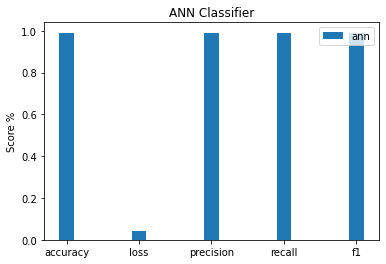

In [19]:
x = ["accuracy", "loss", "precision", "recall", "f1"]
scores = [accuracy, loss, precision, recall, f1]

w = 0.2
    
bar1 = np.arange(len(x))
plt.bar(bar1, scores, w, label="ann")

plt.gcf().set_size_inches(6, 4)
plt.ylabel("Score %")
plt.title("ANN Classifier")
plt.xticks(bar1, x)
plt.legend()
plt.show()

In [20]:
model.save("ANN.h5")

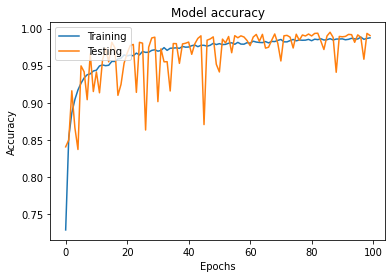

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Testing'], loc='upper left')

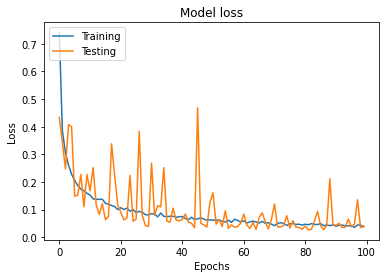

In [22]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epochs') 
plt.legend(['Training', 'Testing'], loc='upper left') 

In [23]:
p_test = model.predict(X_test).argmax(axis=1)
_, _, _, y_test2 = train_test_split(X, Y, train_size=0.7, random_state=42)

<AxesSubplot:>

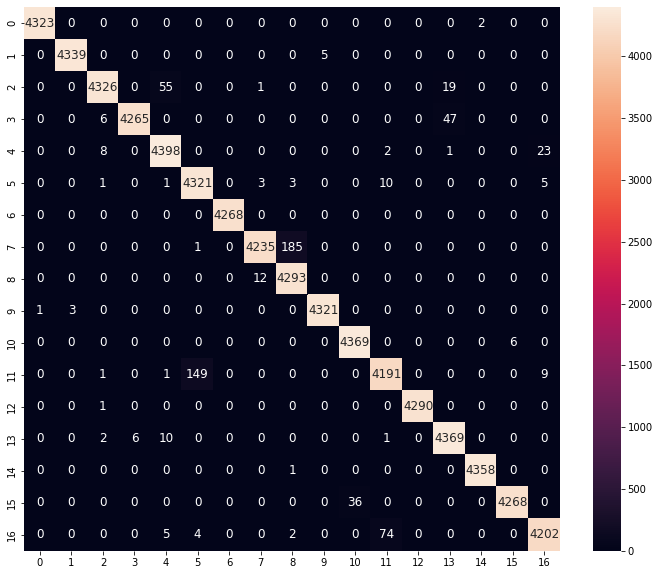

In [24]:
import seaborn as sns

p_test = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test2, p_test)
fig, ax = plt.subplots(figsize=(12,10)) 
sns.heatmap(cm, annot=True, ax=ax, fmt='d', annot_kws={"size": 12})